In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.contrib.tensorboard.plugins import projector

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

num_epoch = 100
batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/shapes_images.npy" )
x_tr = data[:9000,in_timesteps]
y_tr = data[:9000,out_timesteps]

x_te = data[9000:,in_timesteps]
y_te = data[9000:,out_timesteps]

tr_set = data[0:9000, :, :, :]
te_set = data[9000:, :, :, :]

print np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te)

lstm_units = 1024
feature_vector = 1024
latent_dim = 32

# placeholders to hold each frame
x_ = tf.placeholder("float", shape= (None, len(in_timesteps),  64, 64, 3))
y_ = tf.placeholder("float", shape= (None, len(out_timesteps), 64, 64, 3))

# encoder
encoder_conv1_w = tf.get_variable("encoder_conv1_w", shape=[7, 7, 3, 16])
encoder_conv2_w = tf.get_variable("encoder_conv2_w", shape=[5, 5, 16, 32])
encoder_conv3_w = tf.get_variable("encoder_conv3_w", shape=[5, 5, 32, 48])
encoder_conv4_w = tf.get_variable("encoder_conv4_w", shape=[3, 3, 48, 64])

encoder_conv1_b = tf.get_variable("encoder_conv1_b", shape=[16])
encoder_conv2_b = tf.get_variable("encoder_conv2_b", shape=[32])
encoder_conv3_b = tf.get_variable("encoder_conv3_b", shape=[48])
encoder_conv4_b = tf.get_variable("encoder_conv4_b", shape=[64])

def encoder(x):
    out = tf.nn.conv2d(input=x,   filter=encoder_conv1_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv2_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv3_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv4_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv4_b
    out = tf.nn.relu(out)
    out = tf.reshape(out, shape=[-1, 4*4*64])
    return out

# decoder
decoder_conv1_w = tf.get_variable("decoder_conv1_w", shape=[3, 3, 48, 64])
decoder_conv2_w = tf.get_variable("decoder_conv2_w", shape=[5, 5, 32, 48])
decoder_conv3_w = tf.get_variable("decoder_conv3_w", shape=[5, 5, 16, 32])
decoder_conv4_w = tf.get_variable("decoder_conv4_w", shape=[7, 7, 3, 16])

decoder_conv1_b = tf.get_variable("decoder_conv1_b", shape=[48])
decoder_conv2_b = tf.get_variable("decoder_conv2_b", shape=[32])
decoder_conv3_b = tf.get_variable("decoder_conv3_b", shape=[16])
decoder_conv4_b = tf.get_variable("decoder_conv4_b", shape=[3])

def decoder(x):
    out = tf.reshape(x, shape=[-1, 4, 4, 64])
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv1_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 8, 8, 48], padding='SAME') + decoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv2_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 16, 16, 32], padding='SAME') + decoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv3_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 32, 32, 16], padding='SAME') + decoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv4_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 64, 64, 3], padding='SAME') + decoder_conv4_b
    out = tf.nn.sigmoid(out)
    return out

# phi_enc
phi_enc_fc1_w = tf.get_variable("phi_enc_fc1_w", shape=[feature_vector+lstm_units, latent_dim])
phi_enc_fc2_w = tf.get_variable("phi_enc_fc2_w", shape=[latent_dim, latent_dim])

phi_enc_fc1_b = tf.get_variable("phi_enc_fc1_b", shape=[latent_dim])
phi_enc_fc2_b = tf.get_variable("phi_enc_fc2_b", shape=[latent_dim])

phi_enc_mu_w = tf.get_variable("phi_enc_mu_w", shape=[latent_dim, latent_dim])
phi_enc_mu_b = tf.get_variable("phi_enc_mu_b", shape=[latent_dim])

phi_enc_sigma_w = tf.get_variable("phi_enc_sigma_w", shape=[latent_dim, latent_dim])
phi_enc_sigma_b = tf.get_variable("phi_enc_sigma_b", shape=[latent_dim])

def phi_enc(out):
    out = tf.matmul(out, phi_enc_fc1_w) + phi_enc_fc1_b    
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_enc_fc2_w) + phi_enc_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, phi_enc_mu_w)  + phi_enc_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, phi_enc_sigma_w) + phi_enc_sigma_b)
    
    return out_mu, out_std

# phi_decoder
phi_dec_fc1_w = tf.get_variable("phi_dec_fc1_w", shape=[latent_dim+lstm_units, feature_vector])
phi_dec_fc2_w = tf.get_variable("phi_dec_fc2_w", shape=[feature_vector, feature_vector])

phi_dec_fc1_b = tf.get_variable("phi_dec_fc1_b", shape=[feature_vector])
phi_dec_fc2_b = tf.get_variable("phi_dec_fc2_b", shape=[feature_vector])

def phi_dec(out):
    out = tf.matmul(out, phi_dec_fc1_w) + phi_dec_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_dec_fc2_w) + phi_dec_fc2_b
    out = tf.nn.relu(out)
        
    return out

# phi_z
phi_z_fc1_w = tf.get_variable("phi_z_fc1_w", shape=[latent_dim, latent_dim])
phi_z_fc2_w = tf.get_variable("phi_z_fc2_w", shape=[latent_dim, latent_dim])

phi_z_fc1_b = tf.get_variable("phi_z_fc1_b", shape=[latent_dim])
phi_z_fc2_b = tf.get_variable("phi_z_fc2_b", shape=[latent_dim])

def phi_z(out):
    out = tf.matmul(out, phi_z_fc1_w) + phi_z_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_z_fc2_w) + phi_z_fc2_b
    out = tf.nn.relu(out)
    return out

# phi_prior
phi_prior_fc1_w = tf.get_variable("phi_prior_fc1_w", shape=[lstm_units, latent_dim])
phi_prior_fc2_w = tf.get_variable("phi_prior_fc2_w", shape=[latent_dim, latent_dim])

phi_prior_fc1_b = tf.get_variable("phi_prior_fc1_b", shape=[latent_dim])
phi_prior_fc2_b = tf.get_variable("phi_prior_fc2_b", shape=[latent_dim])

phi_prior_mu_w = tf.get_variable("phi_prior_mu_w", shape=[latent_dim, latent_dim])
phi_prior_std_w = tf.get_variable("phi_prior_std_w", shape=[latent_dim, latent_dim])

phi_prior_mu_b = tf.get_variable("phi_prior_mu_b", shape=[latent_dim])
phi_prior_std_b = tf.get_variable("phi_prior_std_b", shape=[latent_dim])

def phi_prior(out):
    out = tf.matmul(out, phi_prior_fc1_w) + phi_prior_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_prior_fc2_w) + phi_prior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, phi_prior_mu_w)  + phi_prior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, phi_prior_std_w) + phi_prior_std_b)
    
    return out_mu, out_std

def tf_kl_gaussgauss(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_sum(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=1)

def tf_kl_gaussgauss2(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_mean(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=0)

def cross_entropy(y_prediction, y):
    prediction_loss = y * tf.log(1e-10 + y_prediction) + (1 - y) * tf.log(1e-10 + 1 - y_prediction)
    return -tf.reduce_sum(prediction_loss, axis=[1, 2, 3])   

def batch_data(source, target, batch_size):

   # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(target)))
    source = source[shuffle_indices]
    target = target[shuffle_indices]

    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]

        yield np.array(source_batch), np.array(target_batch)

# lstm
lstm  = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple=True)
lstm_state = lstm.zero_state(batch_size, tf.float32)

(9000, 19, 64, 64, 3) (9000, 19, 64, 64, 3) (1000, 19, 64, 64, 3) (1000, 19, 64, 64, 3)


In [2]:
y_hat_list = []
phi_prior_out_mu_list = []
       
for i in range(0,len(in_timesteps)): # for i in range(1,len(in_timesteps)):
    
    phi_x_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    #z = phi_prior_out_mu # + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    phi_prior_out_mu_list.append(phi_prior_out_mu)

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
        
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(len(in_timesteps),19):
    
    phi_x_out = encoder(y_hat)

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    phi_prior_out_mu_list.append(phi_prior_out_mu)

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
    
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(20,120):
    
    phi_x_out = encoder(y_hat)

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    z = phi_prior_out_mu # + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    phi_prior_out_mu_list.append(phi_prior_out_mu)

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
    
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)
    
y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])
phi_prior_mu = tf.transpose(tf.stack(phi_prior_out_mu_list), [1, 0, 2])

In [3]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "epoch-100")

INFO:tensorflow:Restoring parameters from epoch-100


# Save Latent Space

In [4]:
mu = sess.run(phi_prior_mu, feed_dict={x_: x_tr[0:batch_size,in_timesteps,:,:,:]})
print np.shape(mu)

(50, 119, 32)


In [5]:
end = 2

temp = mu[end,:,:]
temp = temp[np.newaxis,:]
temp = np.repeat(temp,50,axis=0)
print np.shape(temp)

(50, 119, 32)


# New graph that will interpolate

In [6]:
latent_encodings = tf.placeholder("float", shape= (None, 119, latent_dim))

# original images
y_hat_list = []

# interpolated images
y_hat_interp_list = []

z_list = []
       
for i in range(0,19):
    
    phi_x_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
   
    # latent encoding of current image
    # z = phi_prior_out_mu
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    
    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
    
    # linear interpolate     
    y_hat_interp_list_temp = []
    for alpha in range(0,11):
        z_temp = z + (z - latent_encodings[:,i,:])/1*alpha    
        phi_z_out_temp = phi_z(z_temp)
        phi_dec_out_temp = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out_temp), axis=1)) 
        y_hat = decoder(phi_dec_out_temp)
        y_hat_interp_list_temp.append(y_hat)
        z_list.append(z_temp)
    y_hat_interp_list.append(y_hat_interp_list_temp)
        
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(19,20):
    
    phi_x_out = encoder(y_hat)

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    #z = phi_prior_out_mu
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[latent_dim], mean=0.0, stddev=1.0)
    
    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
    
    # linear interpolate     
    y_hat_interp_list_temp = []
    for alpha in range(0,11):
        z_temp = z + (z - latent_encodings[:,i,:])/1*alpha # z_temp = z + (z - latent_encodings[:,7,:])/1*alpha    
        phi_z_out_temp = phi_z(z_temp)
        phi_dec_out_temp = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out_temp), axis=1)) 
        y_hat = decoder(phi_dec_out_temp)
        y_hat_interp_list_temp.append(y_hat)
        z_list.append(z_temp)
    y_hat_interp_list.append(y_hat_interp_list_temp)
    
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(20,20):
    
    phi_x_out = encoder(y_hat)

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    z = phi_prior_out_mu

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
    
    # linear interpolate     
    y_hat_interp_list_temp = []
    for alpha in range(0,11):
        z_temp = z + (z - latent_encodings[:,7,:])/1*alpha    
        phi_z_out_temp = phi_z(z_temp)
        phi_dec_out_temp = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out_temp), axis=1)) 
        y_hat = decoder(phi_dec_out_temp)
        y_hat_interp_list_temp.append(y_hat)
        z_list.append(z_temp)
    y_hat_interp_list.append(y_hat_interp_list_temp)
    
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)
    
y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])
y_hat_interp_out = tf.transpose(tf.stack(y_hat_interp_list), [2, 0, 1, 3, 4, 5])
phi_prior_mu = tf.transpose(tf.stack(phi_prior_out_mu_list), [1, 0, 2])

# Return results

In [7]:
y_prediction, y_prediction_interp, z = sess.run([y_hat_out, y_hat_interp_out, z_list], feed_dict={x_: x_tr[0:batch_size,in_timesteps,:,:,:], latent_encodings: temp})
print np.shape(y_prediction_interp), np.shape(y_prediction)

(50, 20, 11, 64, 64, 3) (50, 20, 64, 64, 3)


In [8]:
print np.shape(z)
print np.shape(z[0])

print z[0][0,0], z[1][0,0], z[2][0,0]

(220, 50, 32)
(50, 32)
-0.631258 -1.26627 -1.90129


# View results of the interpolation
- start: interpolator start point image
- end  : interpolator end point image (specified at the top)

/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


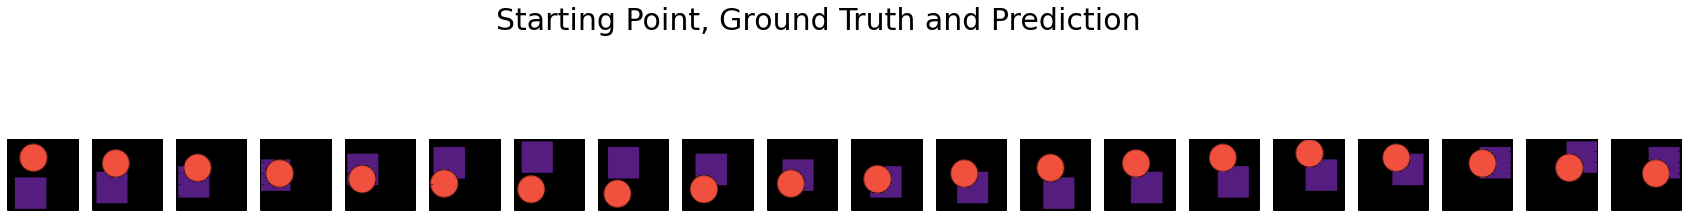

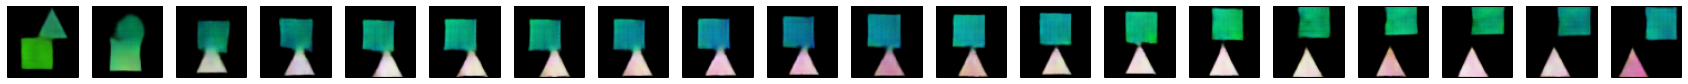

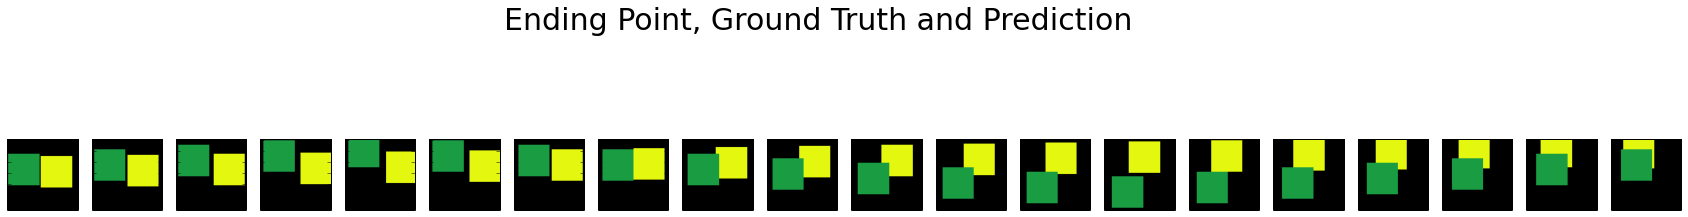

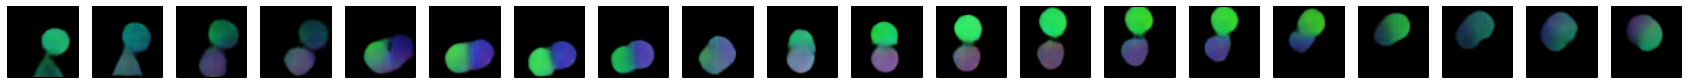

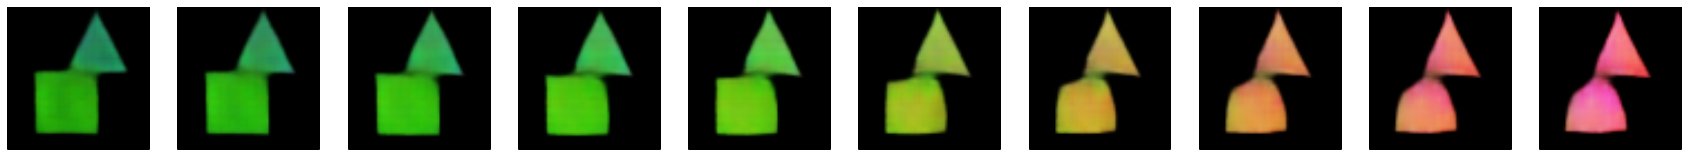

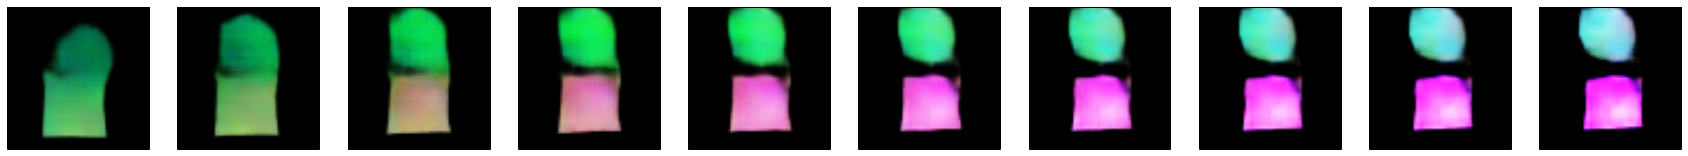

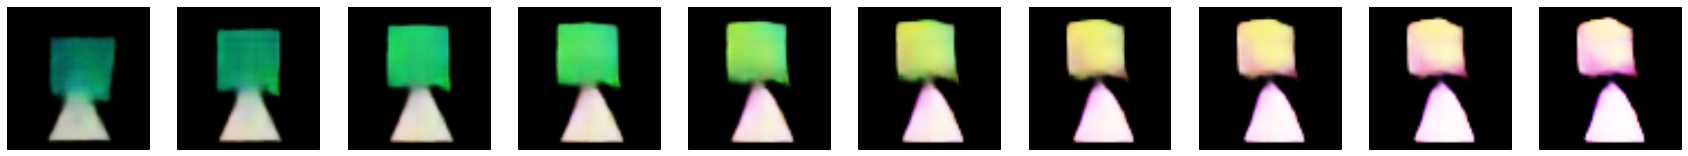

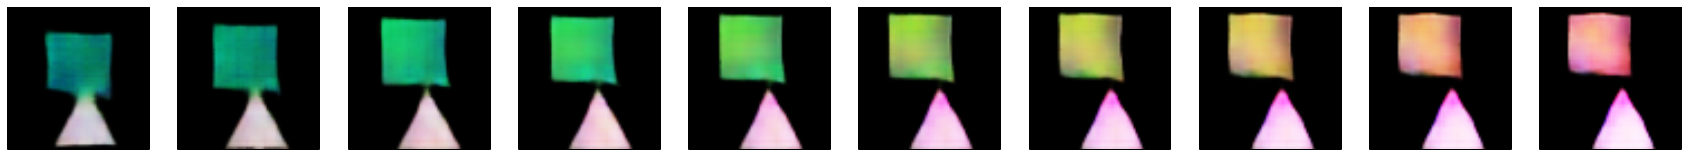

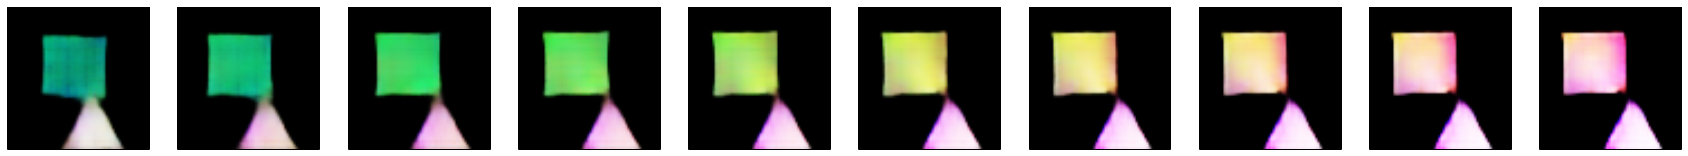

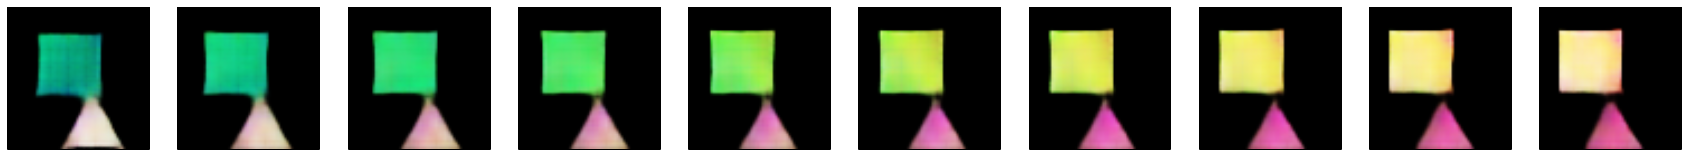

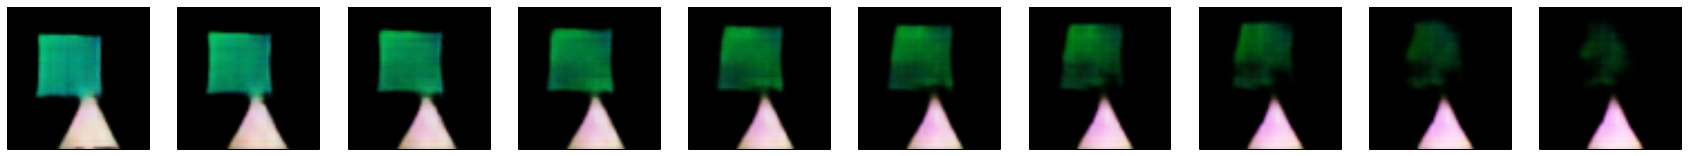

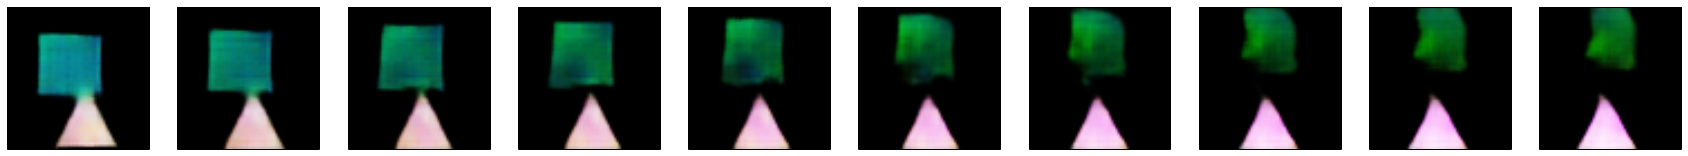

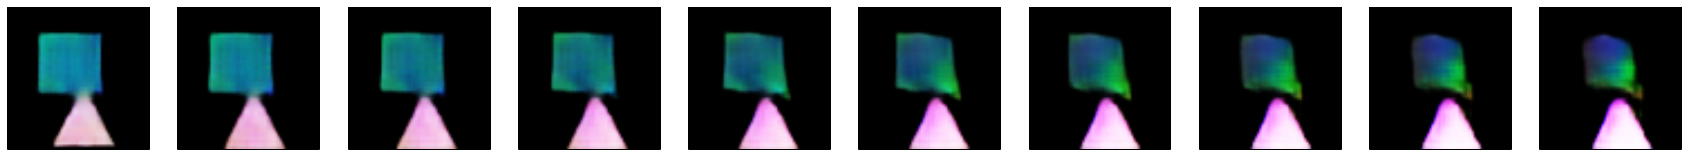

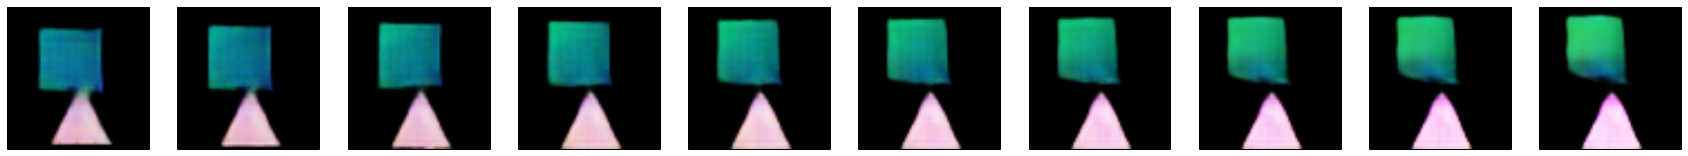

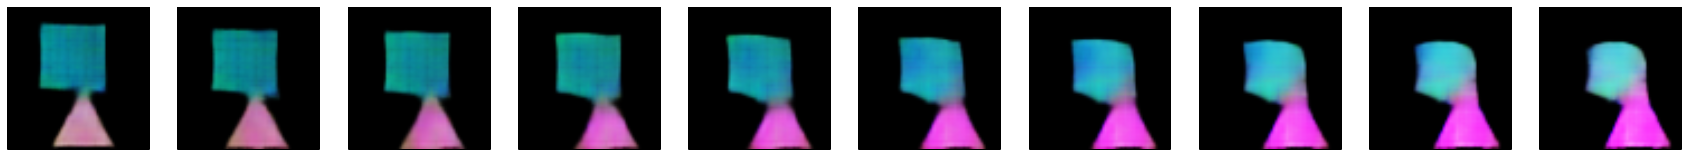

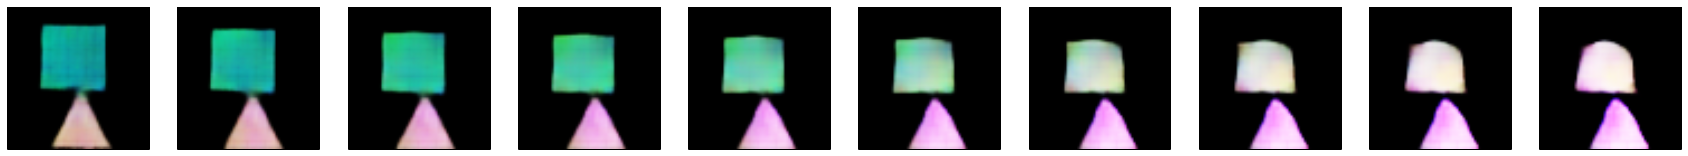

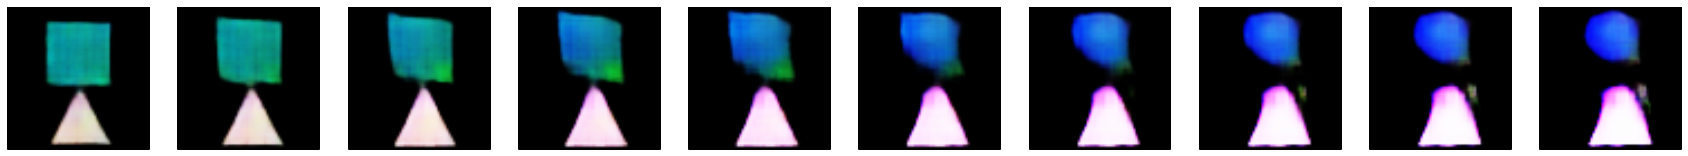

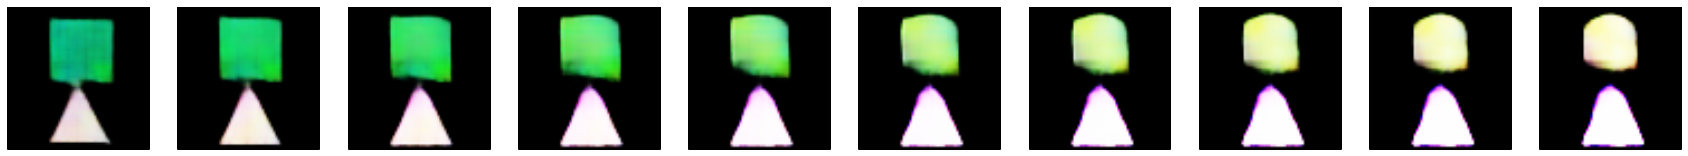

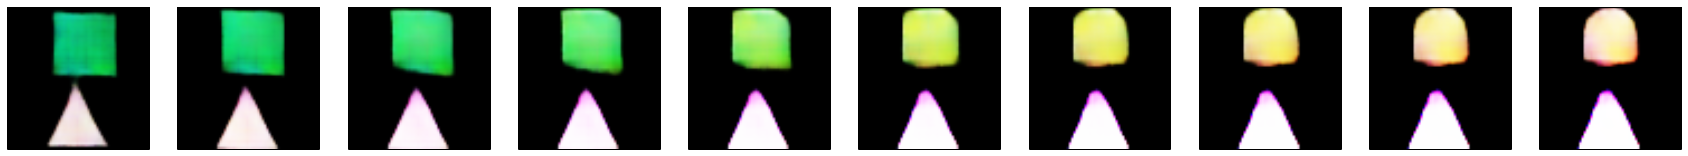

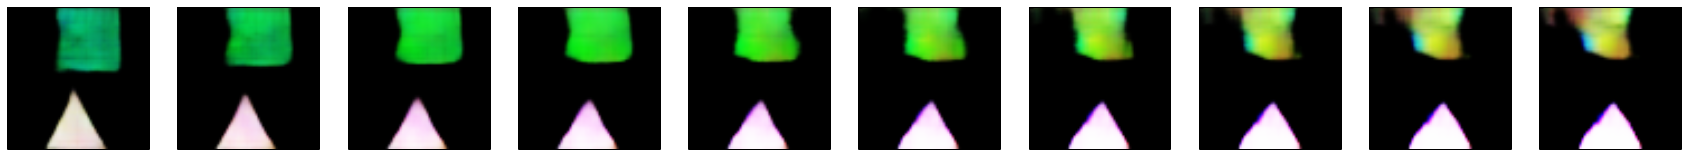

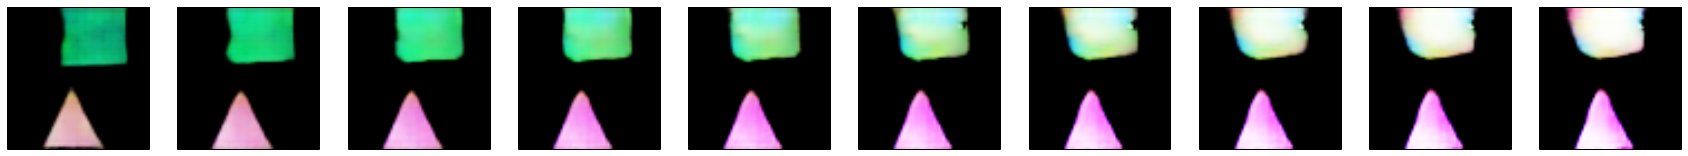

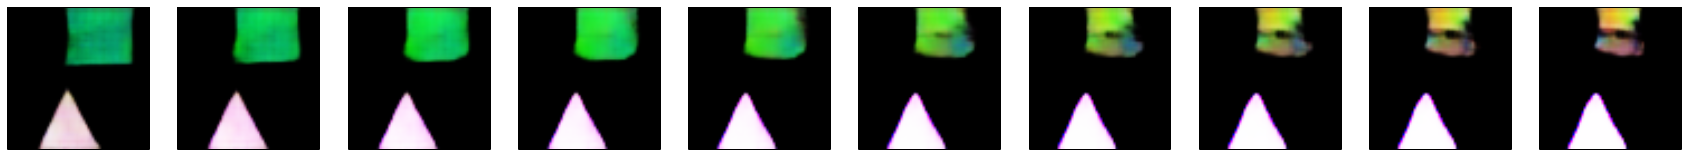

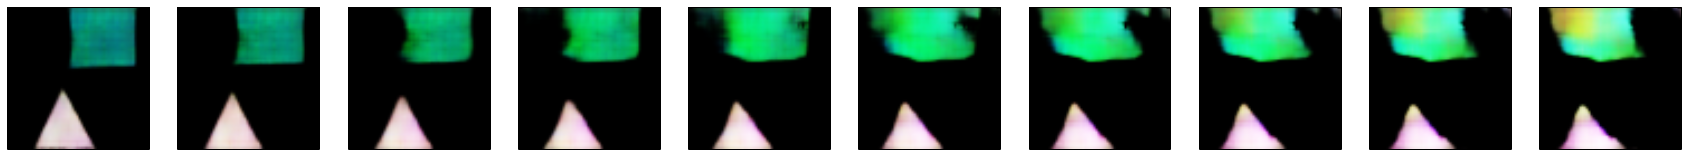

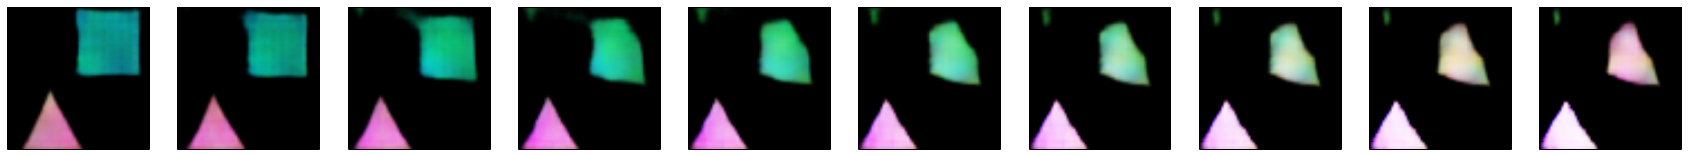

In [9]:
start = 1 # 30

# ground truth for starting point
fig = plt.figure()
fig.suptitle("Starting Point, Ground Truth and Prediction", fontsize=30)
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(te_set[start,i,:,:,:])
    
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(y_prediction[start,i,:,:,:])

# ground truth for ending point 
fig = plt.figure()
fig.suptitle("Ending Point, Ground Truth and Prediction", fontsize=30)
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(te_set[end,i,:,:,:])
    
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(y_prediction[end,i,:,:,:])

fig = plt.figure()
fig.suptitle("Interpolation", fontsize=30)

for i in range(20):
    fig = plt.figure()
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction_interp[start,i,j,:,:,:])

In [10]:
print np.shape(y_prediction_interp[0,0,0,:,:,0])

print np.sum(y_prediction_interp[0,0,0,:,:,0] - y_prediction_interp[0,0,0,:,:,0])

(64, 64)
0.0
